Find ROI from fish scan using NN
====

In [34]:
"""
Download the metadata from the mastersheet

"""

import os
import subprocess

if not os.path.exists("uCT_mastersheet.csv"):
    subprocess.run(
        [
            "wget",
            "https://raw.githubusercontent.com/wahabk/ctfishpy/master/ctfishpy/Metadata/uCT_mastersheet.csv",
        ],
        check=True,
    )

--2024-06-13 12:04:54--  https://raw.githubusercontent.com/wahabk/ctfishpy/master/ctfishpy/Metadata/uCT_mastersheet.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103737 (101K) [text/plain]
Saving to: ‘uCT_mastersheet.csv’

     0K .......... .......... .......... .......... .......... 49% 8.01M 0s
    50K .......... .......... .......... .......... .......... 98% 9.23M 0s
   100K .                                                     100% 2490G=0.01s

2024-06-13 12:04:54 (8.69 MB/s) - ‘uCT_mastersheet.csv’ saved [103737/103737]



In [17]:
# Directory path for RDSF fish data
rdsf_dir = os.path.expanduser(
    "~/zebrafish_rdsf/smb-share:server=rdsfcifs.acrc.bris.ac.uk,share=zebrafish_osteoarthritis"
)

data_dir = os.path.join(rdsf_dir, "DATABASE/uCT/Wahab_clean_dataset/low_res_clean_v3/")

assert os.path.isdir(data_dir)

In [26]:
# Choose a directory to use
n = 70

In [29]:
# Read the images into an array
import pathlib

import cv2
import numpy as np
from tqdm import tqdm


def tifs2array(tif_dir: pathlib.Path) -> np.ndarray:
    """
    Read in all the tifs in a directory and return them as a numpy array

    """
    tifs = [
        cv2.imread(str(tif), cv2.IMREAD_GRAYSCALE)
        for tif in tqdm(sorted(list(tif_dir.glob("*.tiff"))))
    ]

    return np.stack(tifs, axis=0)


def n2dir(n: int) -> pathlib.Path:
    return pathlib.Path(f"{data_dir}/{n:03}/reconstructed_tifs/")


tif_dir = n2dir(n)
print(tif_dir)
array = tifs2array(tif_dir)

/home/mh19137/zebrafish_rdsf/smb-share:server=rdsfcifs.acrc.bris.ac.uk,share=zebrafish_osteoarthritis/DATABASE/uCT/Wahab_clean_dataset/low_res_clean_v3/070/reconstructed_tifs


100%|██████████| 1999/1999 [01:12<00:00, 27.69it/s]


In [43]:
# Get the jaw centre from metadata
import re
from functools import cache

import pandas as pd


@cache
def _metadata() -> pd.DataFrame:
    return pd.read_csv("uCT_mastersheet.csv")


def get_roi(n: int) -> tuple[int, int, int]:
    """Z X Y centre of region of interest"""
    metadata = _metadata()
    centre = metadata.loc[metadata["old_n"] == n, "jaw_center"]

    assert len(centre) == 1
    return tuple(map(int, re.findall(r"\d+", centre.iloc[0])))


roi = get_roi(n)
roi

(1349, 330, 177)

In [46]:
# Crop the image to the jaw centre
def crop_image(
    image: np.ndarray, roi: tuple[int, int, int], size: int = 160
) -> np.ndarray:
    _, width, height = image.shape

    z, x, y = roi
    return image[
        z - size // 2 : z + size // 2,
        width - x - size // 2 : width - x + size // 2,
        height - y - size // 2 : height - y + size // 2,
    ]

cropped_array = crop_image(array, roi)
cropped_array.shape

(160, 160, 160)

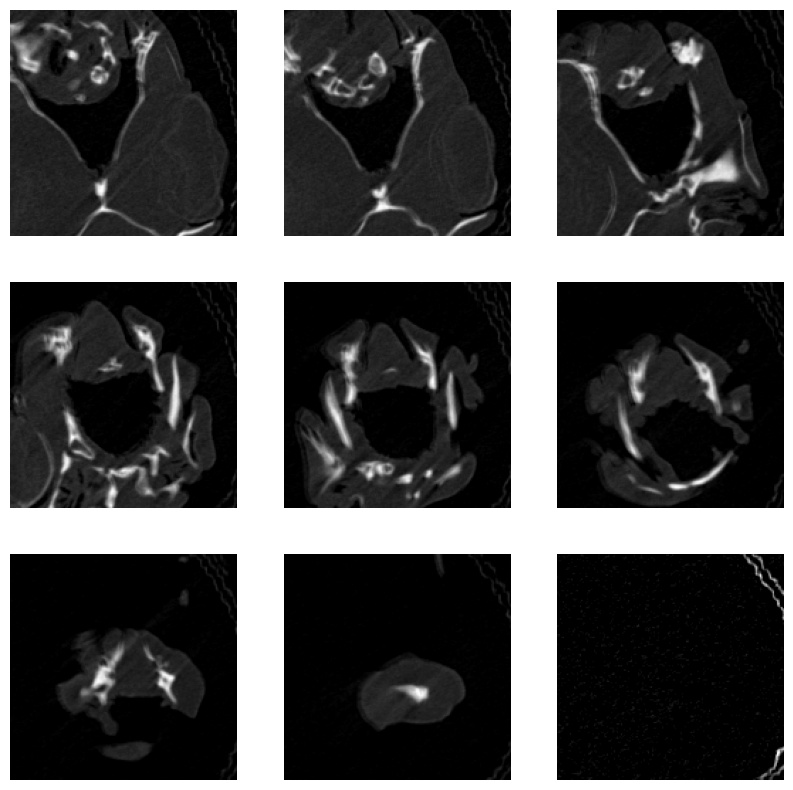

In [47]:
# Show slices of cropped jaw
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for axis, i in zip(
    axes.flat,
    [0, 10, 30, 50, 70, 90, 110, 130, 150],
):
    axis.imshow(cropped_array[i], cmap="gray")
    axis.axis("off")

In [22]:
# Create a model for learning the jaw centre

In [23]:
# Reshape the arrays into a format that the model can use

In [24]:
# Parse the jaw centres to get the right numbers out

In [ ]:
# Train the model on a few jaws, look at training loss etc